# Phase 2: Dynamic Topic Modeling (BERTopic)
**Goal:** Uncover latent economic themes and track their evolution over time.

## Methodology
1.  **Embeddings:** `all-MiniLM-L6-v2` (Sentence Transformers).
2.  **Dimensionality Reduction:** `UMAP`.
3.  **Clustering:** `HDBSCAN`.
4.  **Topic Modeling:** `c-TF-IDF`.
5.  **Dynamic Analyis:** Tracking topics by Date.

## Setup

In [25]:
# !pip install bertopic sentence-transformers umap-learn hdbscan
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import os

# Load Data
DATA_PATH = '../data/master/fed_master_corpus.csv'
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
timestamps = df.date.to_list()
docs = df.text.to_list()

print(f"Loaded {len(docs)} documents.")

Loaded 8297 documents.


## 1. Configure Pipeline
We use a custom configuration to ensure stable results.

In [36]:
# 1. Embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# 2. Dimensionality Reduction
# metric='cosine' is standard for embeddings
umap_search = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=40)

# 3. Clustering
# min_cluster_size=15 ensures we don't get tiny, noisy topics
# min_cluster_size=15 default
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 4. Main Model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_search,
    hdbscan_model=hdbscan_model,
    verbose=True
)

## 2. Fit and Transform (Training)
This may take a few minutes.

In [37]:
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

2025-12-31 16:34:34,153 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/260 [00:00<?, ?it/s]

2025-12-31 16:34:50,262 - BERTopic - Embedding - Completed ✓
2025-12-31 16:34:50,263 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-31 16:35:01,378 - BERTopic - Dimensionality - Completed ✓
2025-12-31 16:35:01,379 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-31 16:35:01,601 - BERTopic - Cluster - Completed ✓
2025-12-31 16:35:01,604 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-31 16:35:01,740 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2029,-1_the_labor_of_market,"[the, labor, of, market, and, in, to, that, jo...",[and that the neutral rate of interest—or the ...
1,0,588,0_percent_inflation_objective_down,"[percent, inflation, objective, down, our, to,...",[inflation is running well below our 2 percent...
2,1,580,1_inflation_down_high_coming,"[inflation, down, high, coming, readings, we, ...",[So we’re actually moving down to—the level th...
3,2,363,2_unemployment_rate_natural_low,"[unemployment, rate, natural, low, percent, at...","[the natural rate of unemployment., The unempl..."
4,3,295,3_monetary_policy_stance_about,"[monetary, policy, stance, about, we, briefly,...","[and monetary policy as “appropriate.” So,, I ..."
...,...,...,...,...,...
102,101,16,101_sheet_guidance_balance_interest,"[sheet, guidance, balance, interest, along, ou...",[along with our strong guidance on interest ra...
103,102,16,102_risks_balance_achieving_too,"[risks, balance, achieving, too, slowly, movin...",[the risks to achieving our employment and inf...
104,103,16,103_guided_fed_actions_stable,"[guided, fed, actions, stable, promote, mandat...",[The Fed’s monetary policy actions are guided ...
105,104,15,104_moderate_growth_economy_recession,"[moderate, growth, economy, recession, potenti...",[The U.S. economy is clearly slowing from the ...


## 3. Visualization (Global Topics)

In [38]:
topic_model.visualize_barchart(top_n_topics=10)

## 4. Dynamic Topic Modeling (Topics over Time)
Crucial for showing the "Evolution" story.

In [39]:
# 4. Calculate Dynamic Topics (Topics over Time)
# This was missing. We calculate how topics evolve over the timestamps.
print("Calculating Topics over Time...")
topics_over_time = topic_model.topics_over_time(docs, timestamps, nr_bins=20)
print(f"Calculated {len(topics_over_time)} time points.")

Calculating Topics over Time...


20it [00:01, 16.69it/s]

Calculated 1340 time points.


Generating Maximized Topic Shares Chart...
�?Saved Maximized Chart to ../reports/figures/acl_topic_evolution_maximized.png


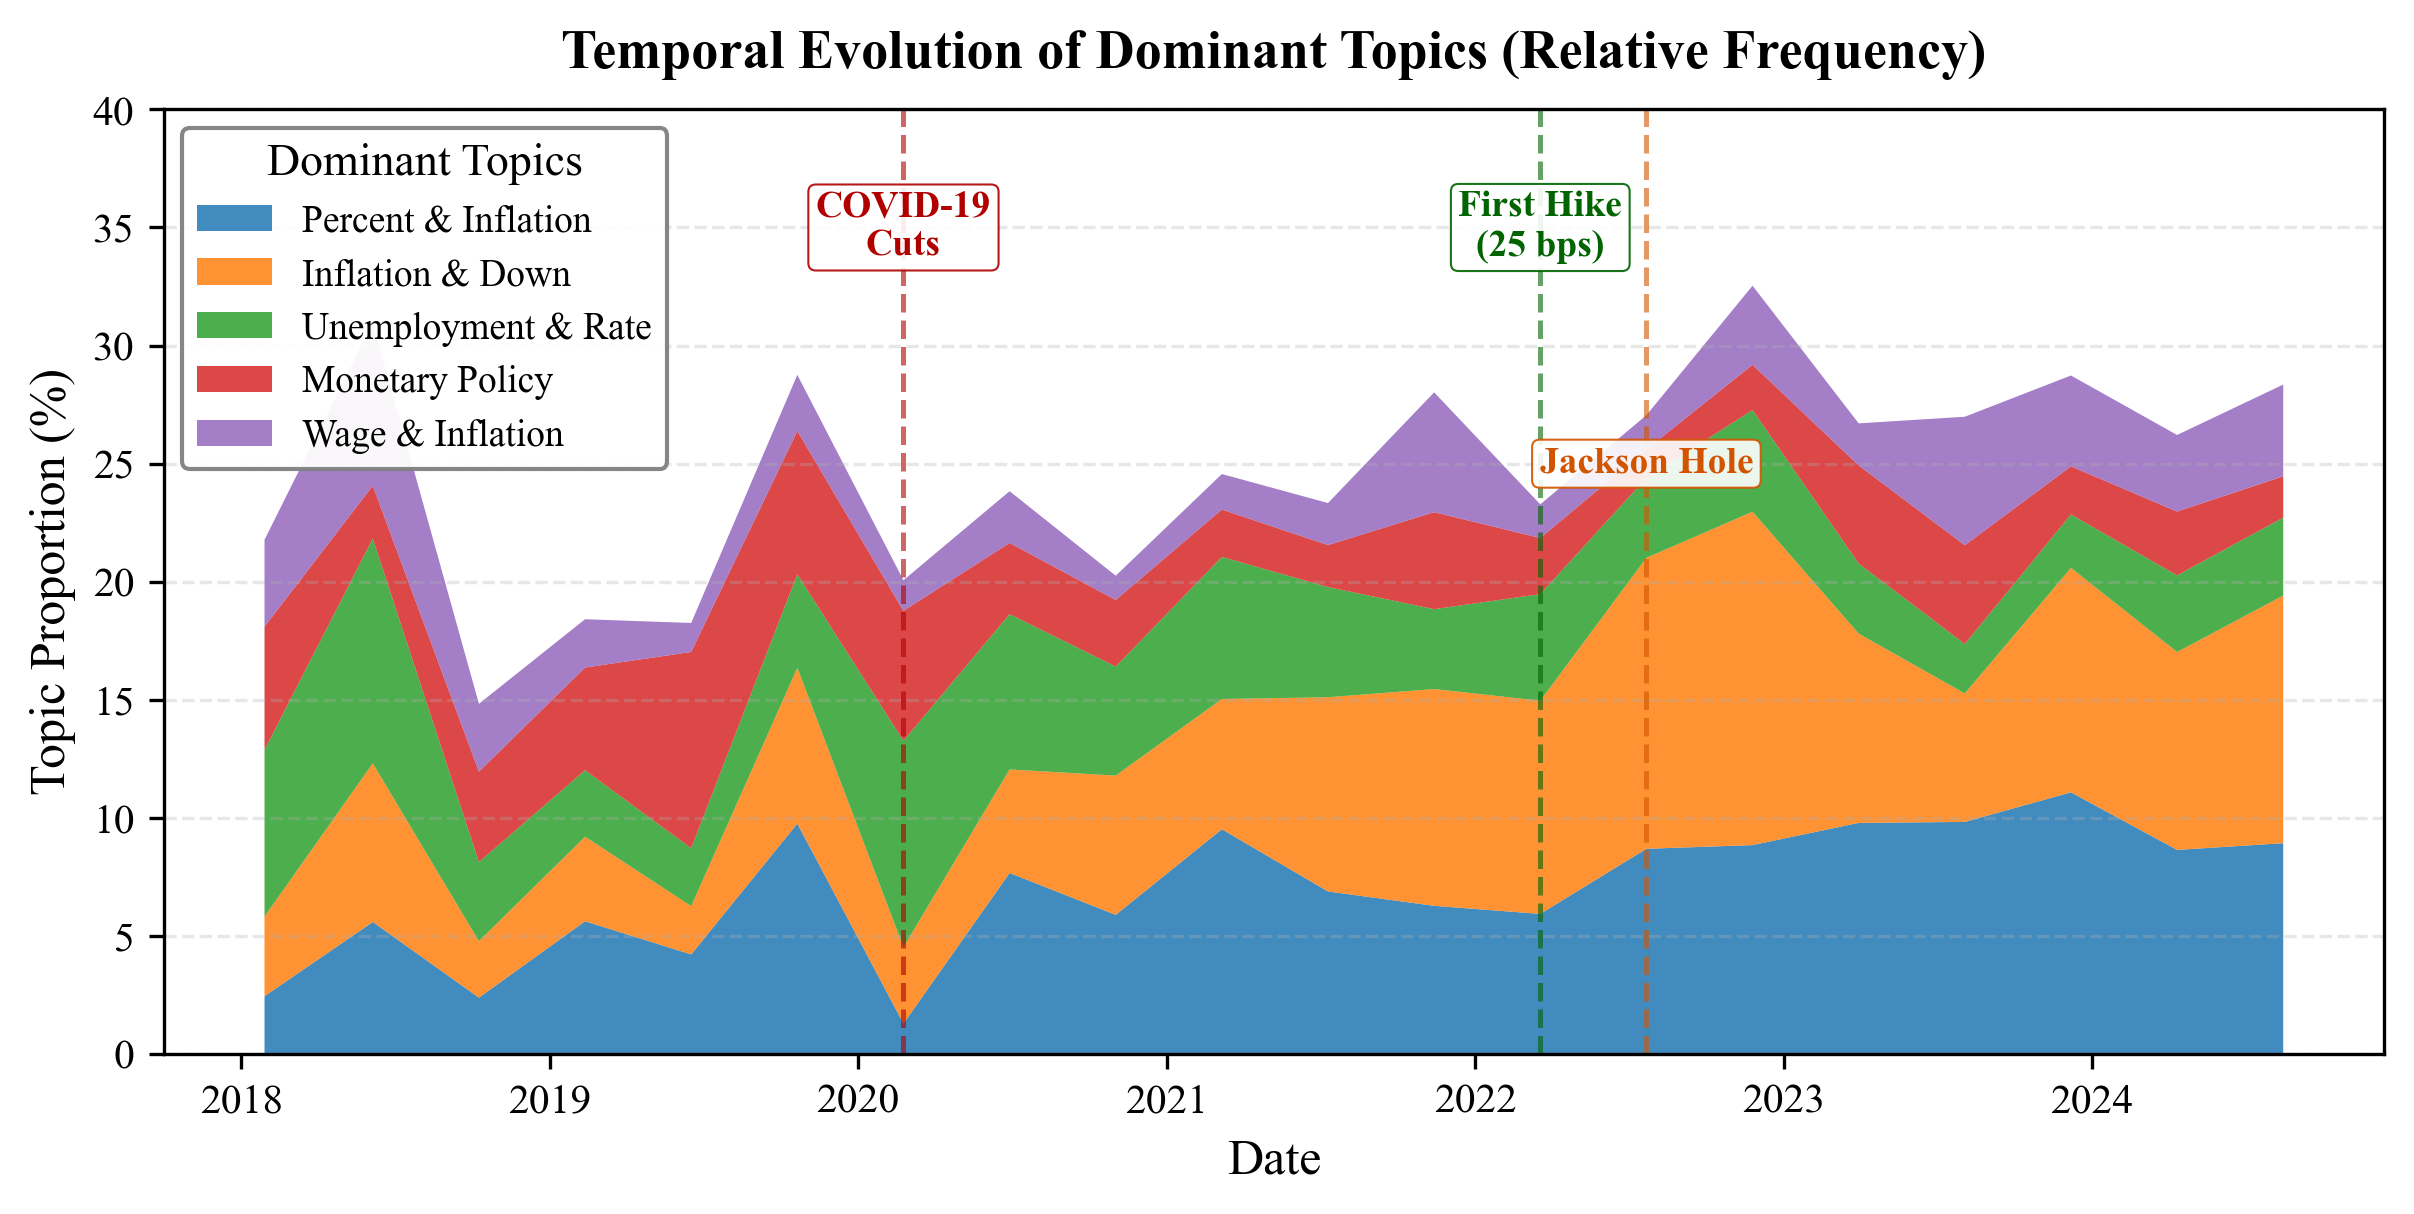

In [41]:
# ==========================================
# 7. Topic Shares Over Time (Optimized Layout)
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_topic_shares_maximized(topic_model, topics_over_time, top_n=5):
    # 1. Calculate TOTAL frequency per time period
    total_freq_per_time = topics_over_time.groupby('Timestamp')['Frequency'].sum()
    
    # 2. Get Top N topics (excluding -1)
    top_topics_info = topic_model.get_topic_info()
    top_5_topics = top_topics_info[top_topics_info['Topic'] != -1].head(top_n)['Topic'].tolist()
    
    # 3. Create DataFrame for Ratios
    df_ratios = pd.DataFrame(index=total_freq_per_time.index)
    for topic in top_5_topics:
            # --- NAMING LOGIC (Identical to Plot 1) ---
        if topic == 0:
             topic_name = 'Percent & Inflation'
        elif topic == 1:
            topic_name = 'Inflation & Down'
        elif topic == 2:
            topic_name = 'Unemployment & Rate'
        elif topic == 3:
            topic_name = 'Monetary Policy'
        elif topic == 4:
            topic_name = 'Wage & Inflation'
        else:
            # Get the top word + "..."
            topic_name = topic_model.get_topic(topic)[0][0] + "..."
        # --------------------

        topic_data = topics_over_time[topics_over_time['Topic'] == topic].set_index('Timestamp')
        topic_data = topic_data.reindex(total_freq_per_time.index, fill_value=0)
        df_ratios[topic_name] = topic_data['Frequency'] / total_freq_per_time

    df_ratios = df_ratios.fillna(0)

    # 4. Visualization Setup (ACL Style + Maximized Area)
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 13,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 9,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'figure.facecolor': 'white',
        'axes.facecolor': 'white'
    })
    
    # Slightly wider to accommodate legend inside without crowding
    fig, ax = plt.subplots(1, 1, figsize=(8.0, 4.0), dpi=300)
    
    # Convert to percentages
    df_percentages = df_ratios * 100
    
    # Stacked area chart
    ax.stackplot(df_percentages.index, df_percentages.T, labels=df_percentages.columns, alpha=0.85)
    
    # Key Events
    key_events = [
        ('2020-03-01', 'COVID-19\nCuts', '#b00000'), 
        ('2022-03-01', 'First Hike\n(25 bps)', '#006400'), 
        ('2022-08-01', 'Jackson Hole', '#d35400')   
    ]
    
    for event_date, event_label, color in key_events:
        event_datetime = pd.to_datetime(event_date)
        time_diffs = [(pd.to_datetime(ts) - event_datetime).total_seconds() for ts in df_percentages.index]
        
        if time_diffs:
            closest_idx = time_diffs.index(min(time_diffs, key=abs))
            
            # Vertical line
            ax.axvline(x=df_percentages.index[closest_idx], color=color, linestyle='--', alpha=0.6, linewidth=1.2)
            
            # --- Dynamic Label Positioning ---
            label_y = 35 
            if 'Jackson Hole' in event_label:
                label_y = 25 
            
            ax.annotate(event_label,
                        xy=(df_percentages.index[closest_idx], label_y),
                        xytext=(df_percentages.index[closest_idx], label_y),
                        ha='center', va='center',
                        fontsize=9, color=color, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9, edgecolor=color, linewidth=0.5))
    
    # --- LEGEND ADJUSTMENT ---
    # Put legend INSIDE the axes at the top right corner
    # framealpha=0.9 makes the background semi-opaque so it doesn't clash with gridlines
    ax.legend(labels=df_percentages.columns.tolist(), 
              loc='upper left',       # Inside the plot, top right
              ncol=1, 
              title="Dominant Topics",
              frameon=True, 
              framealpha=0.95,         # Opaque background to read clearly over data
              edgecolor='gray')
    # -------------------------
    
    ax.set_title('Temporal Evolution of Dominant Topics (Relative Frequency)', fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel('Topic Proportion (%)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    # Y-Axis limit
    ax.set_ylim(0, 40)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Tight Layout to remove white borders and maximize drawing area
    plt.tight_layout(pad=0.5)
    
    # Save
    os.makedirs("../reports/figures", exist_ok=True)
    save_path = "../reports/figures/acl_topic_evolution_maximized.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"�?Saved Maximized Chart to {save_path}")
    
    plt.show()

# Run
print("Generating Maximized Topic Shares Chart...")
if 'topic_model' in locals() and 'topics_over_time' in locals():
    plot_topic_shares_maximized(topic_model, topics_over_time, top_n=5)
else:
    print("⚠️ Data missing. Please run previous cells.")